In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pymc
%matplotlib inline

In [36]:
data = pd.read_csv('data7a.csv')

In [37]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

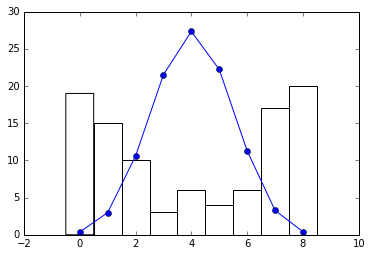

In [38]:
plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white')
plt.plot(np.linspace(0,8,9),scipy.stats.binom.pmf(np.linspace(0,8,9),8,0.504)*100,'o-')
plt.show()

In [42]:
Y = data.y
N = len(Y)
s = pymc.Uniform(name='s',lower=0,upper = 1.0e+4,value=0.01)
b = pymc.Normal(name='b', mu=0.0, tau=1.0e+2)

r = [pymc.Normal(name='r_{0}'.format(i),mu=0,tau=s**(-2)) for i in range(N)]
p = pymc.Lambda('p',lambda r = r,b=b:pymc.invlogit(b+r))

obs = pymc.Binomial(name='obs',n=8,p=p,value=Y,observed=True)
model = pymc.Model([b,s,obs])

In [45]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 201.8 sec